<a href="https://colab.research.google.com/github/MWFK/NLP-from-Zero-to-Hero/blob/main/2_CNN_LSTM_BLSTM_GRU_on_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

2.4.0


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSWL0IL/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSWL0IL/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSWL0IL/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [2]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [4]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

# CNN

In [32]:
# Model Definition with CNN
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.summary()
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 3 # train with 50
history_model_cnn = model_cnn.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d_7 ( (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 178,689
Trainable params: 178,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
782/782 [==============================] - 11s 13ms/step - loss: 0.5309 - accuracy: 0.7034 - val_loss: 

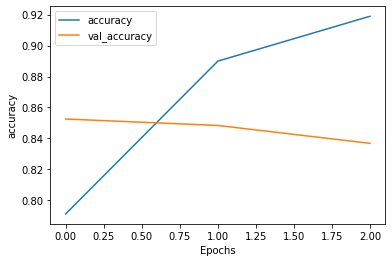

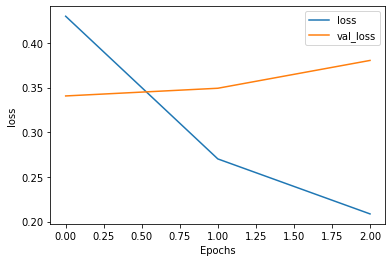

In [33]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history_model_cnn.history[string])
  plt.plot(history_model_cnn.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_model_cnn, 'accuracy')
plot_graphs(history_model_cnn, 'loss')

# LSTM

In [34]:
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

num_epochs = 3 # train with 50
history_model_lstm = model_lstm.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 7         
Total params: 166,477
Trainable params: 166,477
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
782/782 [==============================] - 42s 52ms/step - loss: 0.6145 - accuracy: 0.6090 - val_loss: 0.5039 - val_accuracy: 0.8106
Epoch 2/3
782/782 [==============================] - 40s 52ms/step - loss: 0.3212 - accuracy: 0.8745 -

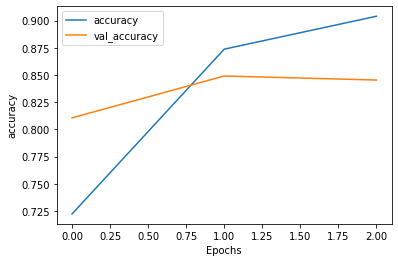

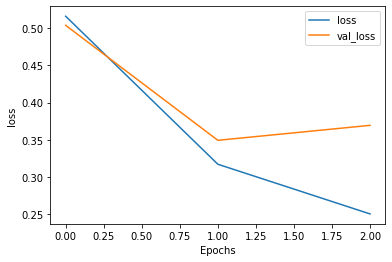

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history_model_lstm.history[string])
  plt.plot(history_model_lstm.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_model_lstm, 'accuracy')
plot_graphs(history_model_lstm, 'loss')

# BLSTM (LSTM)

In [36]:
# Model Definition with BLSTM (LSTM)
model_blstm_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_blstm_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_blstm_lstm.summary()

num_epochs = 3 # train with 50
history_model_blstm_lstm = model_blstm_lstm.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_28 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
782/782 [==============================] - 60s 73ms/step - loss: 0.5819 - accuracy: 0.6734 - val_loss: 0.4121 - val_accuracy: 0.8268
Epoch 2/3
782/782 [==============================] - 57s 72ms/step - loss: 0.3053 - accuracy: 0.8791 -

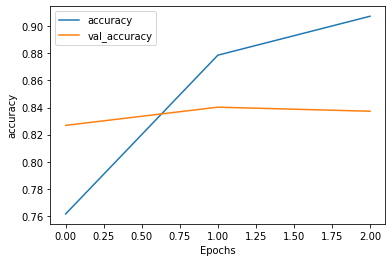

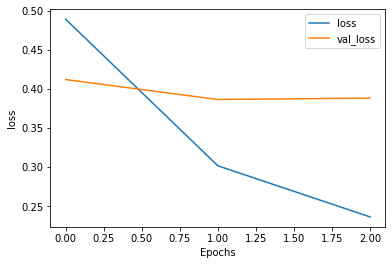

In [37]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history_model_blstm_lstm.history[string])
  plt.plot(history_model_blstm_lstm .history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_model_blstm_lstm , 'accuracy')
plot_graphs(history_model_blstm_lstm , 'loss')

# GRU

In [38]:
# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

num_epochs = 3 # train with 50
history_model_gru = model_gru.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                4800      
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 7         
Total params: 165,005
Trainable params: 165,005
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
782/782 [==============================] - 45s 54ms/step - loss: 0.6202 - accuracy: 0.6118 - val_loss: 0.3600 - val_accuracy: 0.8461
Epoch 2/3
782/782 [==============================] - 41s 53ms/step - loss: 0.3142 - accuracy: 0.8736 -

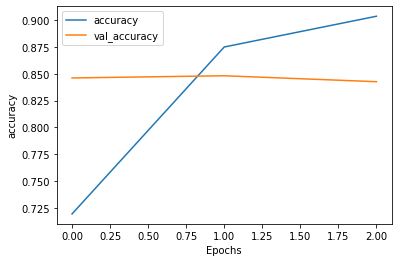

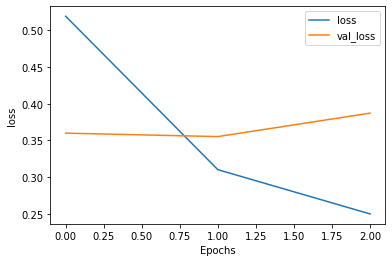

In [39]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history_model_gru.history[string])
  plt.plot(history_model_gru.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_model_gru, 'accuracy')
plot_graphs(history_model_gru, 'loss')

# BLSTM GRU

In [41]:
# Model Definition with BLSTM (GRU)
model_blstm_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_blstm_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_blstm_gru.summary()

num_epochs = 3 # train with 50
history_model_blstm_gru = model_blstm_gru.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
782/782 [==============================] - 63s 77ms/step - loss: 0.6220 - accuracy: 0.6052 - val_loss: 0.3523 - val_accuracy: 0.8471
Epoch 2/3
782/782 [==============================] - 59s 75ms/step - loss: 0.2993 - accuracy: 0.8813 -

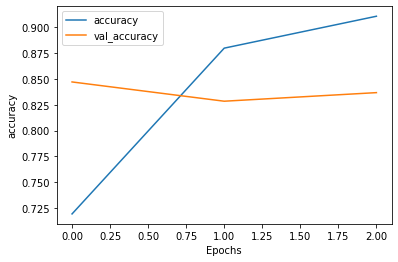

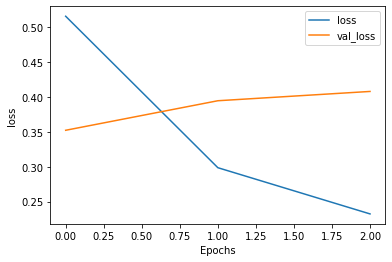

In [42]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history_model_blstm_gru.history[string])
  plt.plot(history_model_blstm_gru.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_model_blstm_gru, 'accuracy')
plot_graphs(history_model_blstm_gru, 'loss')